# Example data processing

This notebook contains example data processing using the output of the [`muse1_default`] example
model.

Output files are mostly in CSV format. The format of output files is documented [here][output-format].

We begin by loading the `model.toml` input file to get the list of milestone years.

[`muse1_default`]: ../../examples/muse1_default/
[output-format]: https://energysystemsmodellinglab.github.io/MUSE_2.0/file_formats/output_files.html

In [ ]:
from pathlib import Path
import pandas as pd
import tomllib

ROOT_DIR = Path("../..")
INPUT_DIR = ROOT_DIR / "examples" / "muse1_default"
OUTPUT_DIR = ROOT_DIR / "tests" / "data" / "muse1_default"

with (INPUT_DIR / "model.toml").open("rb") as f:
    model = tomllib.load(f)

# We need to know the milestone years for processing the assets file
years = model["milestone_years"]

## Load and process output data

We next load the output data. In this case, we want to calculate how much capacity was invested in
different processes for different agents. This information can be found in the `assets.csv` output
file.

The `assets.csv` file contains information about different assets, including when they were
commissioned and decommissioned as well as their capacity. To calculate the overall capacity for a
given agent and process type, we have to process this data. Note that different assets owned by the
same agent may have the same process ID if the agent has reinvested in the same process type in a
different year.

In [ ]:
# The assets.csv file contains info about which assets were invested in and when
assets = pd.read_csv(OUTPUT_DIR / "assets.csv")

# Assets with no decommission_year are effectively decommissioned after time horizon
assets["decommission_year"] = assets["decommission_year"].fillna(years[-1] + 1)

# Calculate capacity for each type of process for each agent
capacity = pd.DataFrame()
for year in years:
    active = assets[(year >= assets["commission_year"]) & (year <= assets["decommission_year"])]

    # This only works because each agent is responsible for one and only one commodity
    cap_sum = active.groupby(["agent_id", "process_id"])["capacity"].sum().reset_index()

    df = pd.DataFrame(cap_sum)
    df["year"] = year

    capacity = pd.concat([capacity, df])

capacity

,agent_id,process_id,capacity,year
0,A1_GAS,gassupply1,24.000000,2020
1,A1_RES,gasboiler,19.000000,2020
0,A1_GAS,gassupply1,33.256781,2025
1,A1_RES,gasboiler,23.939952,2025
0,A1_GAS,gassupply1,40.959166,2030
1,A1_RES,gasboiler,29.879940,2030
0,A1_GAS,gassupply1,50.239148,2035
1,A1_RES,gasboiler,35.999928,2035
0,A1_GAS,gassupply1,55.644737,2040
1,A1_RES,gasboiler,41.939916,2040


## Plot results

Finally, we plot the results.

Note that each of the agents has invested in only one process type; otherwise there would be
multiple bars per plot here.

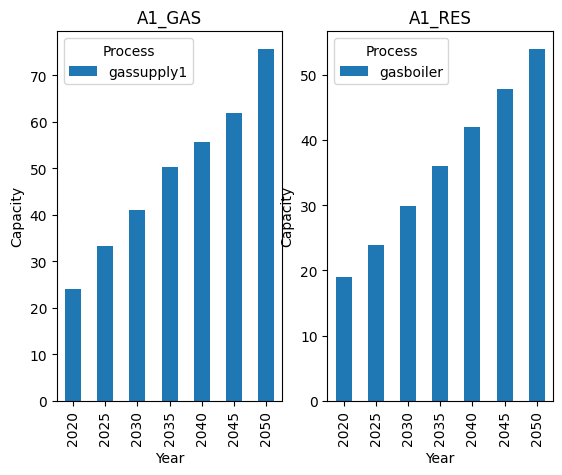

In [ ]:
import matplotlib.pyplot as plt

agents = capacity["agent_id"].unique()
_, axes = plt.subplots(1, len(agents))
for ax, agent in zip(axes, agents):
    capacity[capacity["agent_id"] == agent].pivot(index="year", columns="process_id", values="capacity").plot(kind="bar", ax=ax)
    ax.set_title(agent)
    ax.set_xlabel("Year")
    ax.set_ylabel("Capacity")
    ax.legend(title="Process")